In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

def create_directory(directory):
  if not os.path.exists(directory):
      os.makedirs(directory)

b'hello \xc3\xa9'

'🐍'

the corrected version is: b'Pythn'


how to find a string

-1


**Spelling chekers **

people


In [ ]:
import shutil

with open('/content/drive/MyDrive/Keras/VOCdevkit/VOC2006/contrib.txt', 'r', encoding='utf-8') as labelFile:
  label_lines = labelFile.readlines()

car_images = []
motorbike_images = []
bus_images = []
classes = []
images = []
for line in label_lines[1:]:
  classes.append(line.replace("\"",'').split('|')[1])
  images.append(line.replace("\"",'').split('|')[0])

for i, eachClass in enumerate(classes):
  if "car" in eachClass:
    car_images.append(images[i] + '.png')
  elif "motorbike" in eachClass:
    motorbike_images.append(images[i] + ".png")
  elif "bus" in eachClass:
    bus_images.append(images[i] + ".png")

print(len(car_images))
print(len(motorbike_images))
print(len(bus_images))

494
471
364


In [ ]:
car_path = "/content/drive/MyDrive/Keras/VOCdevkit/dataset/car"
motorbike_path = "/content/drive/MyDrive/Keras/VOCdevkit/dataset/motorbike"
bus_path = "/content/drive/MyDrive/Keras/VOCdevkit/dataset/bus"

if os.path.exists(car_path):
  shutil.rmtree(car_path)
if os.path.exists(motorbike_path):
  shutil.rmtree(motorbike_path)
if os.path.exists(bus_path):
  shutil.rmtree(bus_path)

create_directory(car_path)
create_directory(motorbike_path)
create_directory(bus_path)


In [ ]:
images_path = "/content/drive/MyDrive/Keras/VOCdevkit/VOC2006/PNGImages/"

for img in car_images:
  try:
    shutil.copy(images_path + img, car_path + "/" + img)
  except:
    pass
for img in motorbike_images:
  try:
    shutil.copy(images_path + img, motorbike_path + "/" + img)
  except:
    pass
for img in bus_images:
  try:
    shutil.copy(images_path + img, bus_path + "/" + img)
  except:
    pass

# New Section

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
batch_size = 32
img_height = 160
img_width = 160

In [ ]:
import pathlib
data_dir = '/content/drive/MyDrive/Keras/VOCdevkit/dataset'
data_dir = pathlib.Path(data_dir)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

NameError: ignored

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 655 files belonging to 3 classes.


In [ ]:
class_names = train_dataset.class_names
print(class_names)

['bus', 'car', 'motorbike']


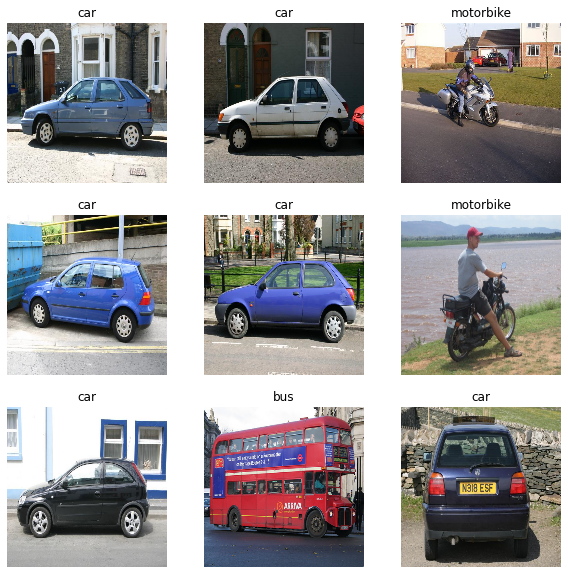

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 17
Number of test batches: 4


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

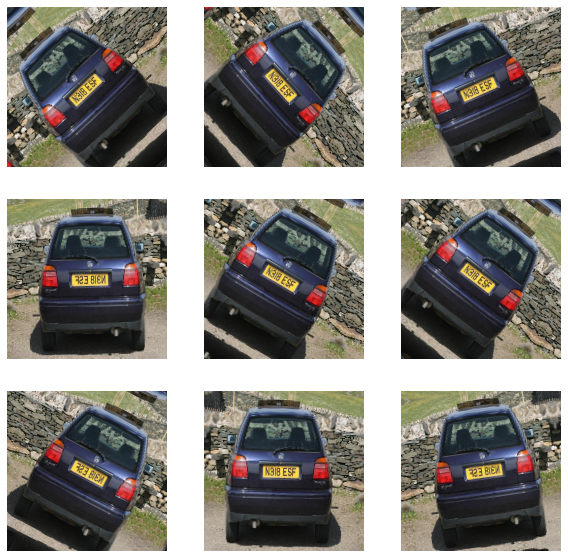

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


**Feature Extraction**

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Freeze the Convolution Base

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

**Add a classification head**

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compile the model
Compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

***Train the model***
After training for 10 epochs, you should see ~94% accuracy on the validation set.

In [ ]:
initial_epochs = 10


In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)

17/17 [==============================] - 15s 571ms/step - loss: 0.9006 - accuracy: 0.2600


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.90
initial accuracy: 0.26


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
21/21 [==============================] - 34s 1s/step - loss: 0.8839 - accuracy: 0.3695 - val_loss: 0.4460 - val_accuracy: 0.3643
Epoch 2/10
21/21 [==============================] - 30s 1s/step - loss: 0.3830 - accuracy: 0.4290 - val_loss: 0.1785 - val_accuracy: 0.4345
Epoch 3/10
21/21 [==============================] - 31s 1s/step - loss: 0.0844 - accuracy: 0.4260 - val_loss: -0.0576 - val_accuracy: 0.4194
Epoch 4/10
21/21 [==============================] - 30s 1s/step - loss: -0.0676 - accuracy: 0.4122 - val_loss: -0.1952 - val_accuracy: 0.4231
Epoch 5/10
21/21 [==============================] - 30s 1s/step - loss: -0.2210 - accuracy: 0.4214 - val_loss: -0.2530 - val_accuracy: 0.4250
Epoch 6/10
21/21 [==============================] - 30s 1s/step - loss: -0.3487 - accuracy: 0.4183 - val_loss: -0.3407 - val_accuracy: 0.4307
Epoch 7/10
21/21 [==============================] - 30s 1s/step - loss: -0.5315 - accuracy: 0.4183 - val_loss: -0.5589 - val_accuracy: 0.4231
Epoch 8/10


Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

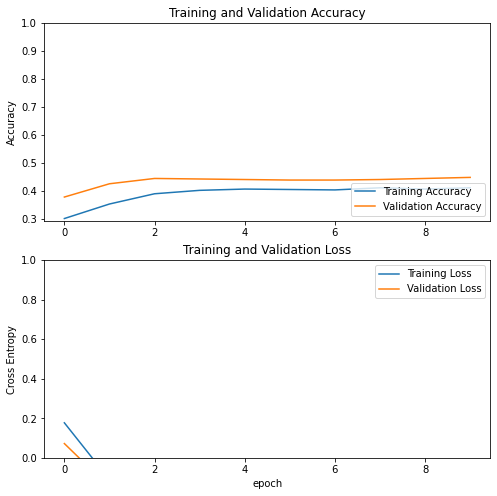

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

***Un-freeze the top layers of the model***
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


Compile the model

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

**Continue training the model**

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
21/21 [==============================] - 15s 407ms/step - loss: -4.1101 - accuracy: 0.4122 - val_loss: -6.7877 - val_accuracy: 0.4478
Epoch 11/20
21/21 [==============================] - 9s 376ms/step - loss: -11.6661 - accuracy: 0.4137 - val_loss: -14.5168 - val_accuracy: 0.4478
Epoch 12/20
21/21 [==============================] - 9s 378ms/step - loss: -18.1811 - accuracy: 0.4153 - val_loss: -20.3300 - val_accuracy: 0.4402
Epoch 13/20
21/21 [==============================] - 9s 379ms/step - loss: -23.8175 - accuracy: 0.4305 - val_loss: -24.9129 - val_accuracy: 0.4383
Epoch 14/20
21/21 [==============================] - 9s 379ms/step - loss: -27.9552 - accuracy: 0.4198 - val_loss: -28.9023 - val_accuracy: 0.4573
Epoch 15/20
21/21 [==============================] - 10s 385ms/step - loss: -32.0524 - accuracy: 0.4397 - val_loss: -32.1427 - val_accuracy: 0.4516
Epoch 16/20
21/21 [==============================] - 10s 383ms/step - loss: -35.4372 - accuracy: 0.4412 - val_loss: -3

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

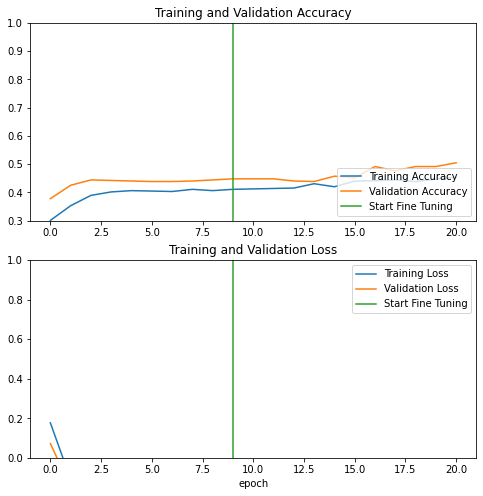

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.3, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 3s 226ms/step - loss: -60.8844 - accuracy: 0.4766
Test accuracy : 0.4765625


Now data pedeiction

Predictions:
 [1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1]
Labels:
 [1 1 2 1 0 2 2 1 1 1 1 2 2 1 1 1 2 2 2 1 2 2 1 1 1 2 1 0 0 1 2 1]


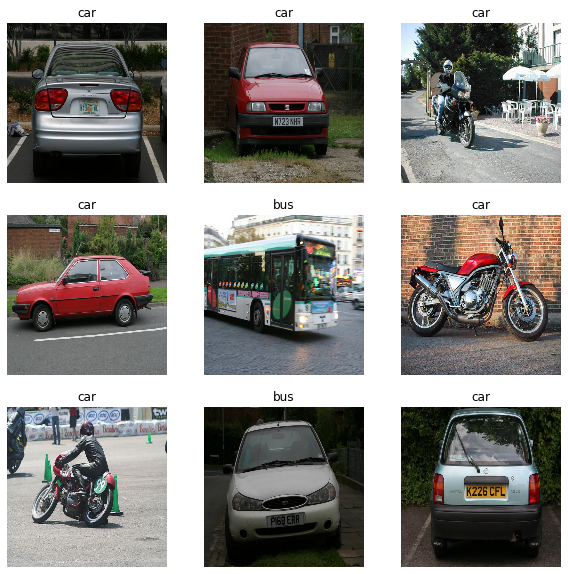

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
num_classes = len(class_names)
print(num_classes)

3


***Task 3***

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'), #addition
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'), #addition
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 15
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/15
21/21 [==============================] - 10s 358ms/step - loss: 1.1049 - accuracy: 0.3664 - val_loss: 1.0726 - val_accuracy: 0.4080
Epoch 2/15
21/21 [==============================] - 9s 353ms/step - loss: 1.0707 - accuracy: 0.4458 - val_loss: 1.0107 - val_accuracy: 0.5237
Epoch 3/15
21/21 [==============================] - 9s 353ms/step - loss: 1.0187 - accuracy: 0.4824 - val_loss: 0.8748 - val_accuracy: 0.5787
Epoch 4/15
21/21 [==============================] - 9s 356ms/step - loss: 0.8860 - accuracy: 0.5954 - val_loss: 0.5934 - val_accuracy: 0.7552
Epoch 5/15
21/21 [==============================] - 9s 355ms/step - loss: 0.7760 - accuracy: 0.6473 - val_loss: 0.6171 - val_accuracy: 0.7438
Epoch 6/15
21/21 [==============================] - 9s 353ms/step - loss: 0.6582 - accuracy: 0.6748 - val_loss: 0.6946 - val_accuracy: 0.6565
Epoch 7/15
21/21 [==============================] - 9s 351ms/step - loss: 0.6609 - accuracy: 0.6779 - val_loss: 0.5053 - val_accuracy: 0.7723
Epoch

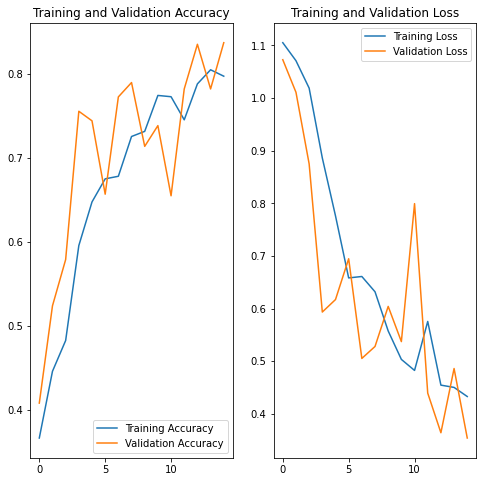

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Task 4**

**Double neurons **

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 15
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/15
21/21 [==============================] - 11s 367ms/step - loss: 1.3584 - accuracy: 0.3893 - val_loss: 1.0666 - val_accuracy: 0.3947
Epoch 2/15
21/21 [==============================] - 9s 364ms/step - loss: 1.0371 - accuracy: 0.4687 - val_loss: 1.0576 - val_accuracy: 0.4953
Epoch 3/15
21/21 [==============================] - 9s 359ms/step - loss: 0.9142 - accuracy: 0.5863 - val_loss: 0.6597 - val_accuracy: 0.7211
Epoch 4/15
21/21 [==============================] - 9s 362ms/step - loss: 0.7382 - accuracy: 0.6687 - val_loss: 0.5814 - val_accuracy: 0.7476
Epoch 5/15
21/21 [==============================] - 9s 361ms/step - loss: 0.6451 - accuracy: 0.7160 - val_loss: 0.5289 - val_accuracy: 0.7742
Epoch 6/15
21/21 [==============================] - 9s 360ms/step - loss: 0.5617 - accuracy: 0.7634 - val_loss: 0.4436 - val_accuracy: 0.8273
Epoch 7/15
21/21 [==============================] - 9s 358ms/step - loss: 0.5975 - accuracy: 0.7420 - val_loss: 0.5549 - val_accuracy: 0.7343
Epoch

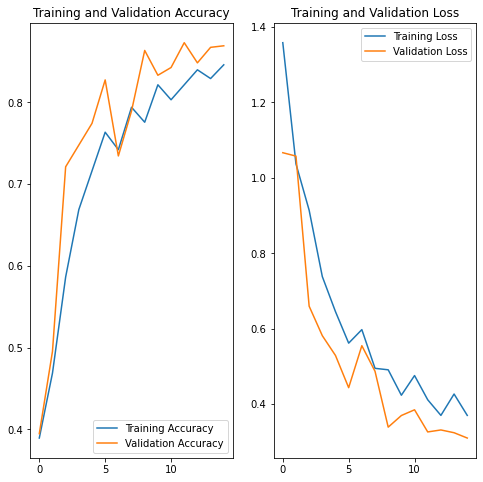

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Half neurons**

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 15
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/15
21/21 [==============================] - 10s 357ms/step - loss: 1.1226 - accuracy: 0.4076 - val_loss: 1.0633 - val_accuracy: 0.4061
Epoch 2/15
21/21 [==============================] - 9s 354ms/step - loss: 1.0644 - accuracy: 0.4519 - val_loss: 1.0275 - val_accuracy: 0.4687
Epoch 3/15
21/21 [==============================] - 9s 356ms/step - loss: 0.9778 - accuracy: 0.5328 - val_loss: 0.8769 - val_accuracy: 0.5617
Epoch 4/15
21/21 [==============================] - 9s 354ms/step - loss: 0.8539 - accuracy: 0.6198 - val_loss: 0.6733 - val_accuracy: 0.7021
Epoch 5/15
21/21 [==============================] - 9s 355ms/step - loss: 0.7953 - accuracy: 0.6336 - val_loss: 0.6726 - val_accuracy: 0.6888
Epoch 6/15
21/21 [==============================] - 10s 387ms/step - loss: 0.7390 - accuracy: 0.6748 - val_loss: 0.6098 - val_accuracy: 0.7249
Epoch 7/15
21/21 [==============================] - 10s 354ms/step - loss: 0.6395 - accuracy: 0.7130 - val_loss: 0.4905 - val_accuracy: 0.7951
Epo

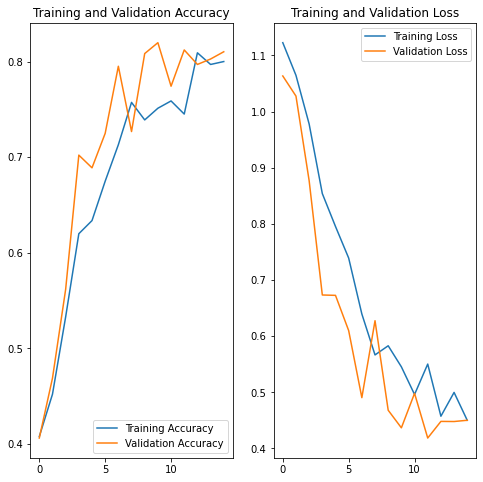

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()